# Квантильная регрессия

В качестве исходных данных взят открытый датасет стоимости квартир в Москве.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
sns.set_style("whitegrid")

In [ ]:
data = pd.read_csv("moscow_dataset_2020.csv")
data.head()

,wallsMaterial,floorNumber,floorsTotal,totalArea,kitchenArea,latitude,longitude,price
0,brick,1,5.0,18.0,3.0,55.723379,37.628577,5600000
1,brick,1,5.0,15.0,3.0,55.725980,37.671031,4650000
2,brick,1,5.0,11.9,1.5,55.735976,37.657817,2990000
3,brick,1,7.0,18.4,3.0,55.786698,37.595321,4390000
4,brick,2,5.0,17.6,2.0,55.767894,37.665920,4890000


In [ ]:
data.shape

(63945, 8)

In [ ]:
data["price"] = data["price"] / 1000000

In [ ]:
data.isna().sum()

,0
wallsMaterial,2
floorNumber,0
floorsTotal,0
totalArea,0
kitchenArea,0
latitude,0
longitude,0
price,0


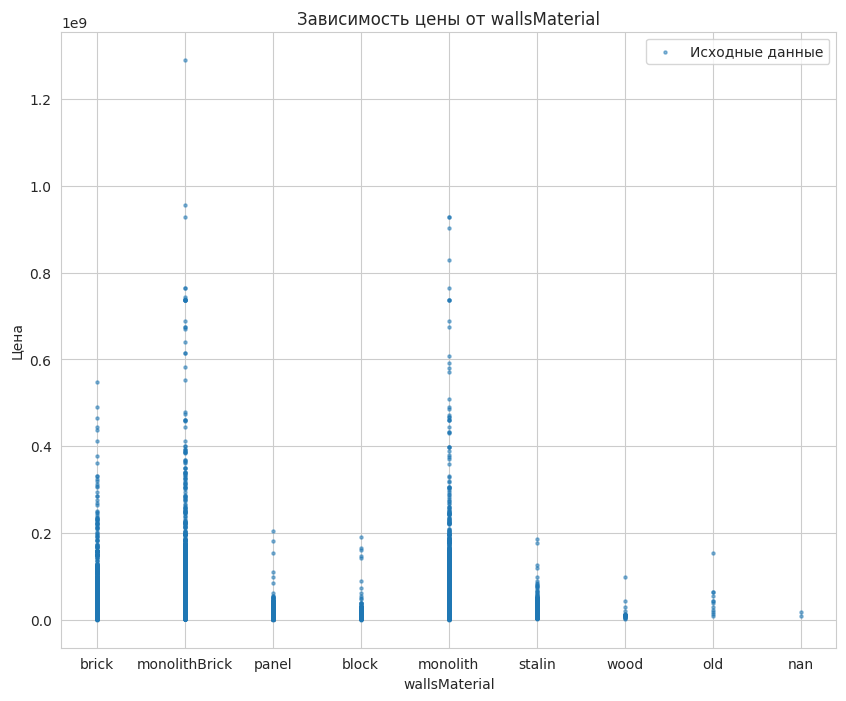

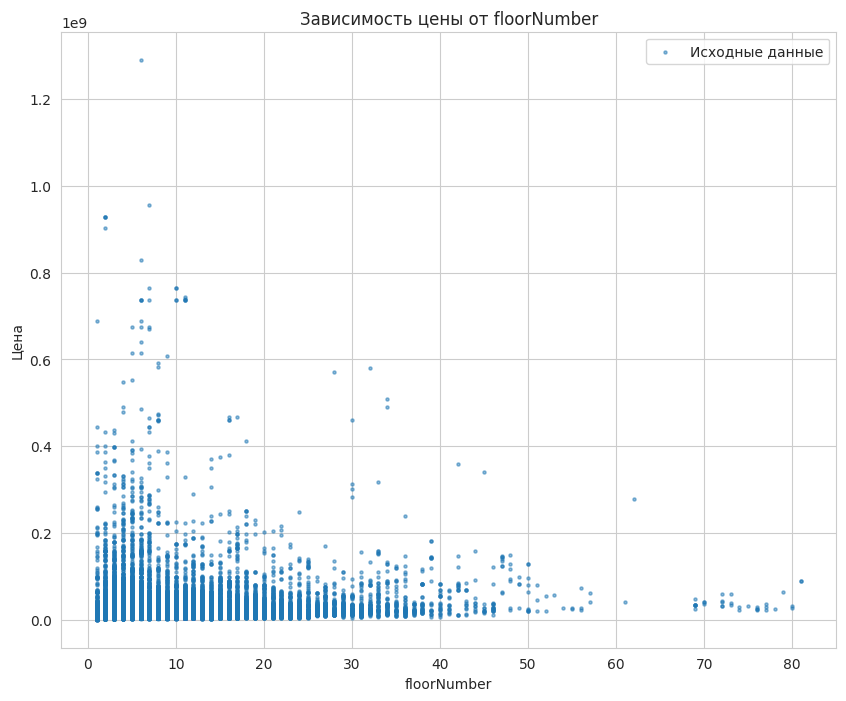

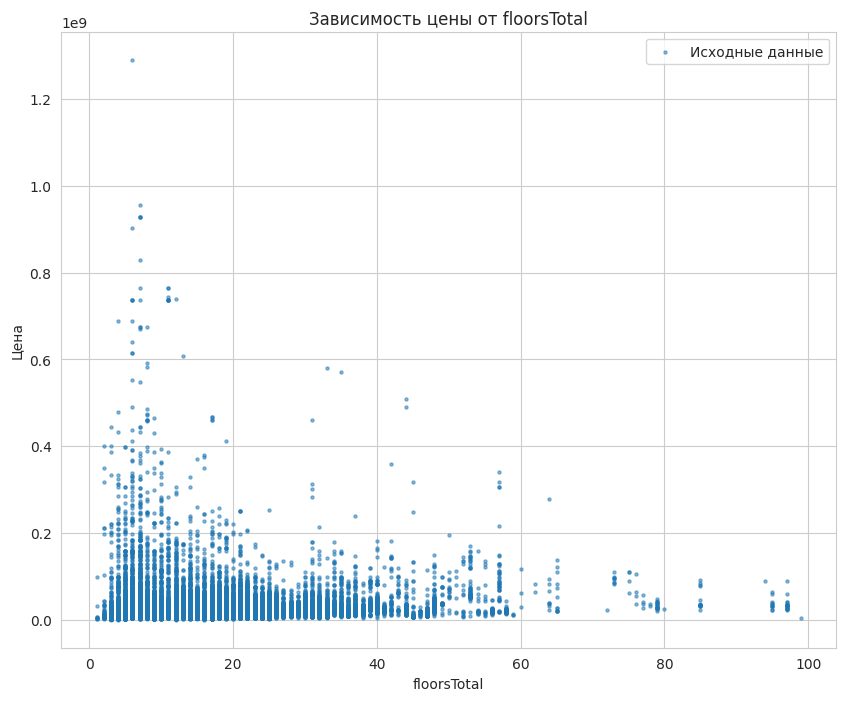

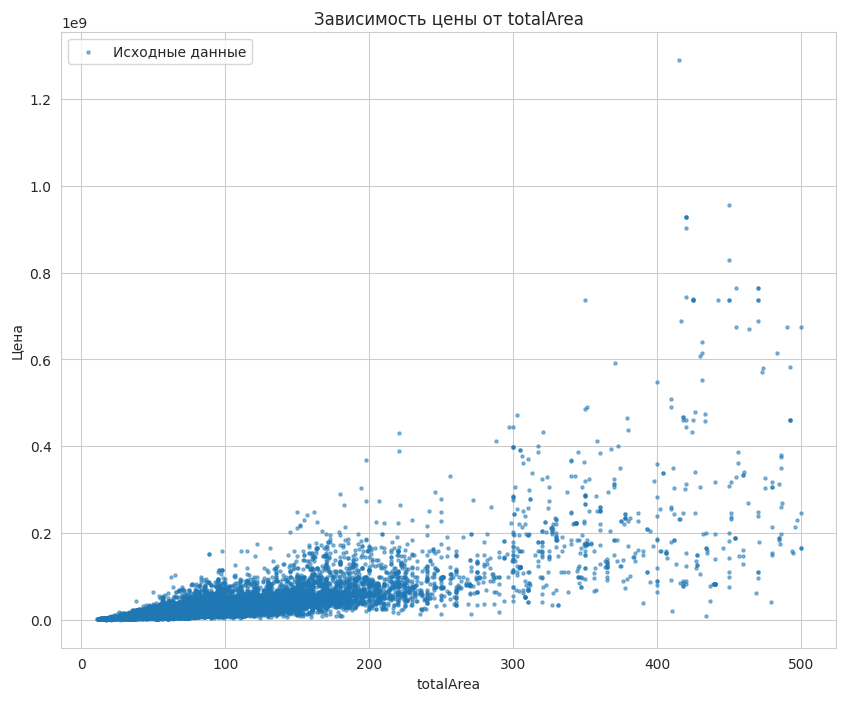

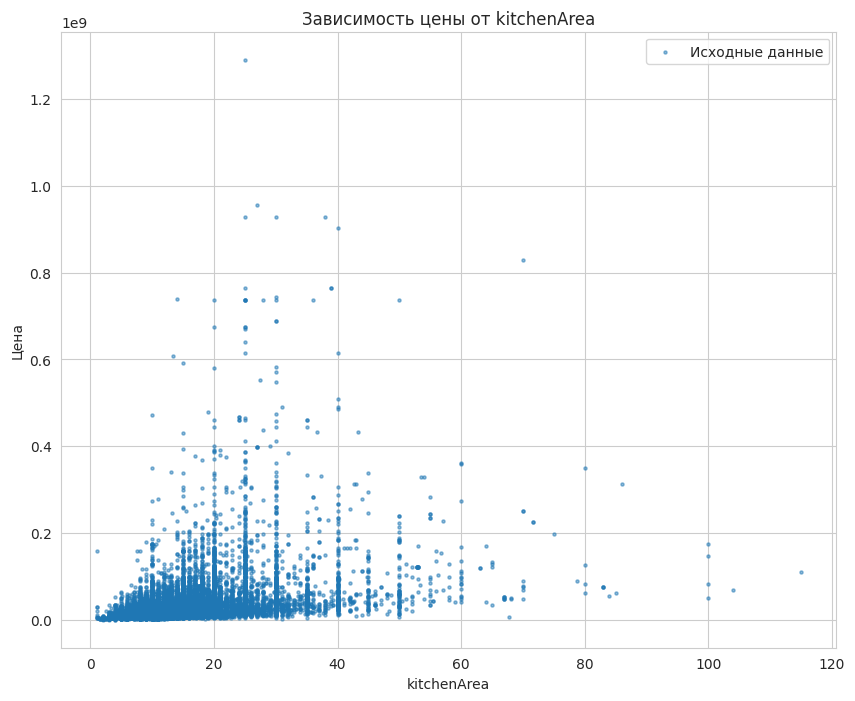

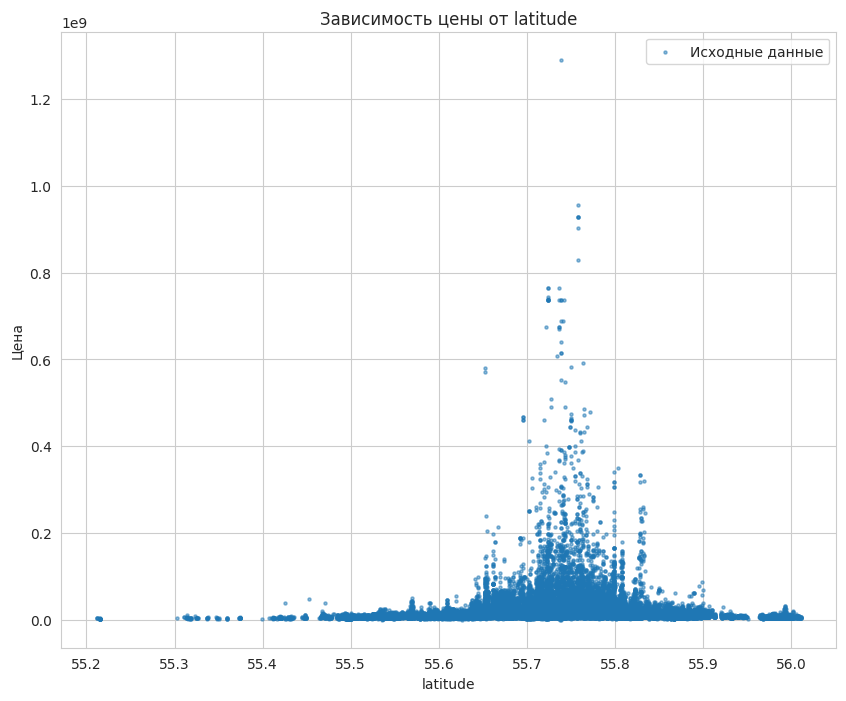

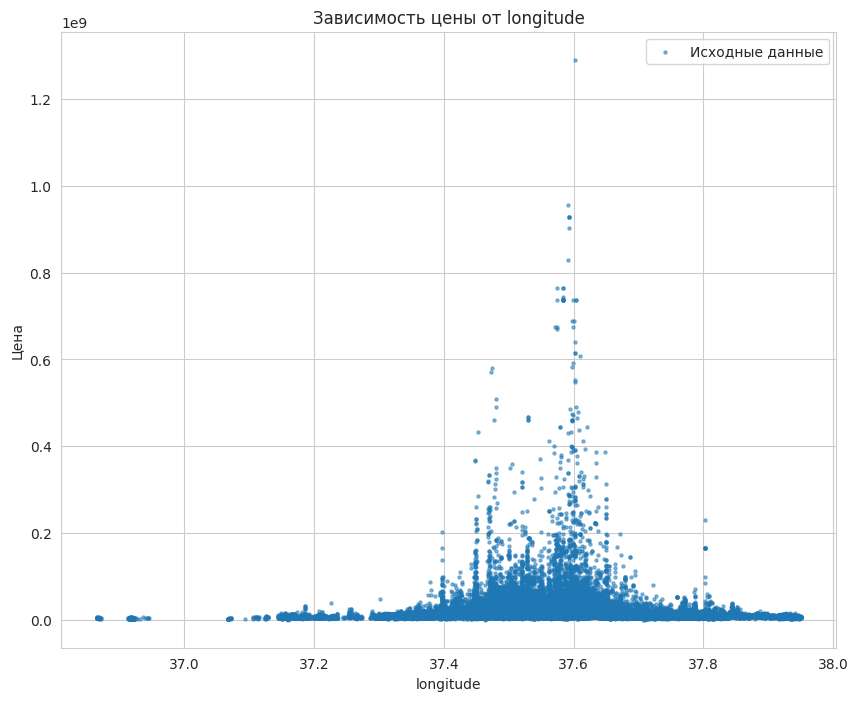

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

data['wallsMaterial'] = data['wallsMaterial'].astype(str)

# Построение графиков для каждого признака
for feature in data.columns.drop('price'):
    plt.figure(figsize=(10, 8))
    plt.scatter(data[feature], data['price'], s=5, alpha=0.5, label="Исходные данные")
    plt.xlabel(feature)
    plt.ylabel("Цена")
    plt.title(f"Зависимость цены от {feature}")
    plt.legend()
    plt.show()


# 1. LinearRegression

In [ ]:
import random
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [ ]:
data = pd.get_dummies(data, columns=['wallsMaterial'], drop_first=True, dtype=np.int8)

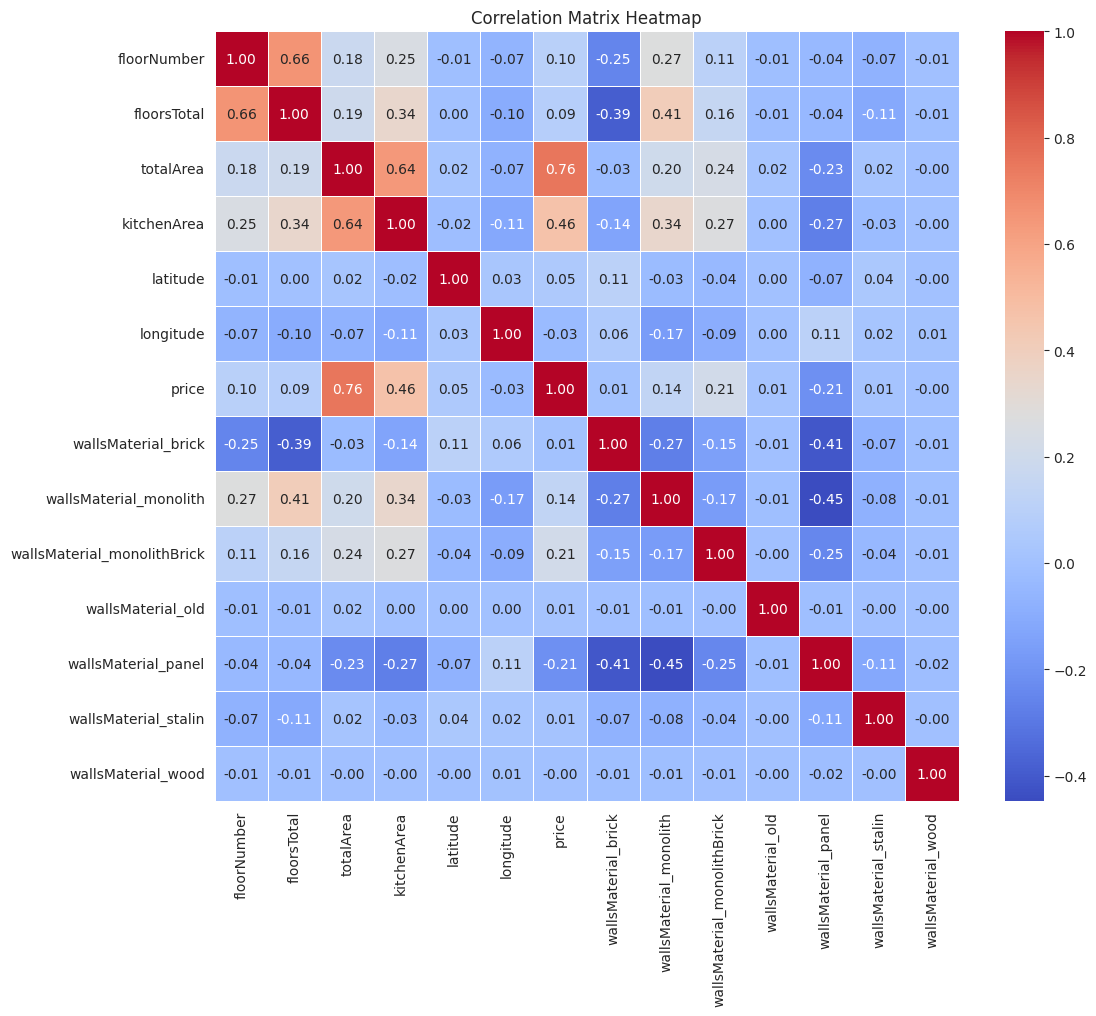

In [ ]:
correlation_matrix = data.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()


In [ ]:
data1 = data.drop(['floorsTotal','wallsMaterial_panel'], axis=1) # убираем мультиколлинеарность признаков

In [ ]:
X = data1.drop('price', axis=1)
y = data1['price']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
lin_reg = LinearRegression().fit(X_train, y_train)

In [ ]:
lin_reg.coef_

array([-0.15058291,  0.54137533, -0.2523    ,  9.18437476,  4.3349047 ,
        1.96408884,  1.94485163,  6.45321828, -2.42481697, -0.42499367,
        1.97356417])

In [ ]:
lin_reg.intercept_

-691.4480006280527

In [ ]:
lin_reg_pred = lin_reg.predict(X_test)

In [ ]:
print(f"MAPE =  {mean_absolute_percentage_error(y_test, lin_reg_pred)}")
print(f"MAE = {mean_absolute_error(y_test, lin_reg_pred)}")

MAPE =  0.5629239541118028
MAE = 8.510124892272538


In [ ]:
lin_reg_results = pd.DataFrame({
    "Входные данные": list(X_test.to_dict(orient="records")),
    "Реальные значения": y_test.values,
    "Предсказанные значения": lin_reg_pred,
    "Ошибка": np.abs(y_test.values - lin_reg_pred)
})

# Находим строку с наибольшей ошибкой
lin_reg_example = lin_reg_results.loc[lin_reg_results["Ошибка"].idxmax()]
lin_reg_output = {
    "Класс модели": "LinearRegression",
    "Входные данные": lin_reg_example["Входные данные"],
    "Выход модели": lin_reg_example["Предсказанные значения"],
    "Реальное значение": lin_reg_example["Реальные значения"],
    "Ошибка": lin_reg_example["Ошибка"]
}

In [ ]:
lin_reg_output

{'Класс модели': 'LinearRegression',
 'Входные данные': {'floorNumber': 2,
  'totalArea': 420.0,
  'kitchenArea': 40.0,
  'latitude': 55.758225,
  'longitude': 37.592608,
  'wallsMaterial_brick': 0,
  'wallsMaterial_monolith': 1,
  'wallsMaterial_monolithBrick': 0,
  'wallsMaterial_old': 0,
  'wallsMaterial_stalin': 0,
  'wallsMaterial_wood': 0},
 'Выход модели': 202.5461298140225,
 'Реальное значение': 903.062159,
 'Ошибка': 700.5160291859775}

Линейная регрессия может неверно экстраполировать значения для объектов, которые значительно отличаются по площади от большинства других объектов в наборе данных. Такие крупные объекты (420 кв.м) могут стоить непропорционально дороже. Таким образом, линейная регрессия не способна корректно учитывать нелинейные зависимости, характерные для объектов премиум-класса. Линейные модели лучше подходят для данных с более стабильной и равномерной структурой цен.

# 2. XGBoost

In [ ]:
X = data.drop('price', axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae', random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

In [ ]:
print(f"MAPE =  {mean_absolute_percentage_error(y_test, y_pred_xgb)}")
print(f"MAE = {mean_absolute_error(y_test, y_pred_xgb)}")

MAPE =  0.12863543048131157
MAE = 2.989112428052327


In [ ]:
xgb_results = pd.DataFrame({
    "Входные данные": list(X_test.to_dict(orient="records")),
    "Реальные значения": y_test.values,
    "Предсказанные значения": y_pred_xgb,
    "Ошибка": np.abs(y_test.values - y_pred_xgb)
})

xgb_example = xgb_results.loc[xgb_results["Ошибка"].idxmax()]
xgb_output = {
    "Класс модели": "XGBoost",
    "Входные данные": xgb_example["Входные данные"],
    "Выход модели": xgb_example["Предсказанные значения"],
    "Реальное значение": xgb_example["Реальные значения"],
    "Ошибка": xgb_example["Ошибка"]
}
xgb_output

{'Класс модели': 'XGBoost',
 'Входные данные': {'floorNumber': 11,
  'floorsTotal': 12.0,
  'totalArea': 360.0,
  'kitchenArea': 18.0,
  'latitude': 55.725331,
  'longitude': 37.573717,
  'wallsMaterial_brick': 0,
  'wallsMaterial_monolith': 0,
  'wallsMaterial_monolithBrick': 1,
  'wallsMaterial_old': 0,
  'wallsMaterial_panel': 0,
  'wallsMaterial_stalin': 0,
  'wallsMaterial_wood': 0},
 'Выход модели': 555.4723,
 'Реальное значение': 173.0,
 'Ошибка': 382.4722900390625}

Основная причина ошибки связана с тем, что модель XGBoost, хотя и способна учитывать нелинейные зависимости, оказалась чувствительной к большому значению площади и расположению. В результате, модель значительно завысила стоимость объекта.Цена на такие квартиры может изменяться ступенчато, так как в стоимость включаются дополнительные параметры класса жилья, такие как престижность локации и инфраструктура.

# 3. Quantile Regression with XGBoost

In [ ]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from functools import partial

# Класс XGBQuantile
class XGBQuantile(xgb.XGBRegressor):
    def __init__(self, quant_alpha=0.95, quant_delta=1.0, quant_thres=1.0, quant_var=1.0, **kwargs):
        self.quant_alpha = quant_alpha
        self.quant_delta = quant_delta
        self.quant_thres = quant_thres
        self.quant_var = quant_var
        super().__init__(**kwargs)

    def fit(self, X, y):
        custom_objective = partial(self.quantile_loss, alpha=self.quant_alpha,
                                   delta=self.quant_delta, threshold=self.quant_thres, var=self.quant_var)
        super().set_params(objective=custom_objective)
        super().fit(X, y)
        return self

    @staticmethod
    def quantile_loss(y_true, y_pred, alpha, delta, threshold, var):
        x = y_true - y_pred
        grad = (x < (alpha - 1.0) * delta) * (1.0 - alpha) - ((x >= (alpha - 1.0) * delta) & (x < alpha * delta)) * x / delta - alpha * (x > alpha * delta)
        hess = ((x >= (alpha - 1.0) * delta) & (x < alpha * delta)) / delta
        grad = (np.abs(x) < threshold) * grad - (np.abs(x) >= threshold) * (2 * np.random.randint(2, size=len(y_true)) - 1.0) * var
        hess = (np.abs(x) < threshold) * hess + (np.abs(x) >= threshold)
        return grad, hess



# Стандартизация целевой переменной
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, random_state=42)

# Параметры для квантильной регрессии
params = {
    'learning_rate': 0.03,
    'n_estimators': 500,
    'max_depth': 4,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'verbosity': 0
}

# Обучение моделей для квантилей 0.1, 0.5 и 0.9
quantiles = [0.1, 0.5, 0.9]
y_pred_quantiles = {}

for quant in quantiles:
    model = XGBQuantile(quant_alpha=quant, quant_delta=1.0, quant_thres=1.0, quant_var=1.0, **params)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    quant_key = f'q_{int(quant * 100)}'
    y_pred_quantiles[quant_key] = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Обратное преобразование y_test к оригинальному масштабу
y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Оценка метрик для каждого квантиля
for quant in quantiles:
    quant_key = f'q_{int(quant * 100)}'
    if quant_key in y_pred_quantiles:
        mae = mean_absolute_error(y_test_orig, y_pred_quantiles[quant_key])
        mape = mean_absolute_percentage_error(y_test_orig, y_pred_quantiles[quant_key])
        print(f"Quantile: {quant}")
        print(f"MAE: {mae}")
        print(f"MAPE: {mape}")
        print("-" * 30)


Quantile: 0.1
MAE: 5.09865636833004
MAPE: 0.12823955589425123
------------------------------
Quantile: 0.5
MAE: 169.89688695033138
MAPE: 16.155765990135883
------------------------------
Quantile: 0.9
MAE: 83.03402186995947
MAPE: 7.1053724019118265
------------------------------


In [ ]:
# Пример худшего предсказания для квантиля 0.1

y_pred_q10 = y_pred_quantiles['q_10']

# Вычисление абсолютной ошибки для квантиля 0.1
errors_q10 = np.abs(y_test_orig - y_pred_q10)

max_error_index_q10 = errors_q10.argmax()

worst_example_q10 = {
    "Класс модели": "Quantile Regression XGBoost (0.1 квантиль)",
    "Входные данные": X_test.iloc[max_error_index_q10].to_dict(),
    "Предсказанное значение": y_pred_q10[max_error_index_q10],
    "Реальное значение": y_test_orig[max_error_index_q10],
    "Ошибка": errors_q10[max_error_index_q10]
}

# Вывод результата
worst_example_q10

{'Класс модели': 'Quantile Regression XGBoost (0.1 квантиль)',
 'Входные данные': {'floorNumber': 7.0,
  'floorsTotal': 7.0,
  'totalArea': 455.0,
  'kitchenArea': 25.0,
  'latitude': 55.736828,
  'longitude': 37.574004,
  'wallsMaterial_brick': 0.0,
  'wallsMaterial_monolith': 1.0,
  'wallsMaterial_monolithBrick': 0.0,
  'wallsMaterial_old': 0.0,
  'wallsMaterial_panel': 0.0,
  'wallsMaterial_stalin': 0.0,
  'wallsMaterial_wood': 0.0},
 'Предсказанное значение': 43.018936,
 'Реальное значение': 768.127199,
 'Ошибка': 725.1082628427735}

Основная причина ошибки в том, что квантильная регрессия на 0.1 предназначена для предсказания нижней границы интервала, что привело к сильному смещению стоимости вниз. Модель недооценивает высококлассные объекты, так как информация о факторах, важных для премиум-объектов, отсутствует в обучающих данных.

# Качество моделей

1. XGBoost показала лучшие результаты среди всех моделей, обеспечивая значительно более точные предсказания благодаря способности улавливать сложные зависимости между признаками и ценой. <br>

2. Линейная регрессия значительно уступает в точности, поскольку не справляется с нелинейными зависимостями и характеристиками премиальных объектов. <br>

3. Quantile Regression XGBoost с квантилями 0.1 и 0.9 предоставляет полезные предсказания для оценивания диапазона цен (нижняя и верхняя границы), но медианное предсказание на квантиле 0.5 имеет высокую ошибку, что делает его менее полезным для оценки средней стоимости.